# Most similar molecules

In [142]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

def get_smiles(file):
    with open(file, 'r') as f:
        content = f.readlines()
        smiles = content[-2].split()[0]
    return(smiles)

In [157]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
all_local_reps = qmi.generate_atomic_representations(data, molecule_size)

In [166]:
id1 = np.where(mol_names == 'dsgdb9nsd_003664')[0][0]

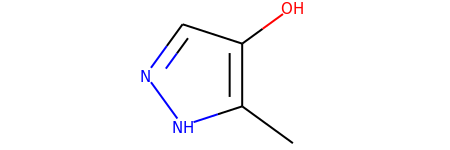

In [167]:
Chem.MolFromSmiles(get_smiles('/home/misa/datasets/qm9/dsgdb9nsd_003664.xyz'))

In [168]:
id2 = np.where(mol_names == 'dsgdb9nsd_003700')[0][0]

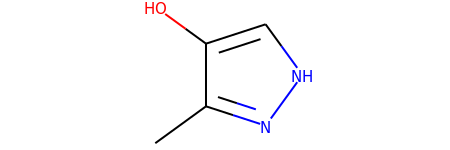

In [169]:
Chem.MolFromSmiles(get_smiles('/home/misa/datasets/qm9/dsgdb9nsd_003700.xyz'))

In [176]:
data[id1][:,0]

array([6., 6., 6., 8., 6., 7., 7., 1., 1., 1., 1., 1., 1.])

In [177]:
data[id2][:,0]

array([6., 6., 7., 7., 6., 6., 8., 1., 1., 1., 1., 1., 1.])

# Find molecules

In [1]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi

In [2]:
def get_element_symbol(Z):
    if int(Z) == 1:
        return('H')
    elif int(Z) == 6:
        return('C')
    elif int(Z) == 7:
        return('N')
    elif int(Z) == 8:
        return('O')
    else:
        raise ValueError('Symbol for given charge not available')

In [3]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
all_local_reps = qmi.generate_atomic_representations(data, molecule_size)

In [4]:
# split up alchemical potential by element
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')
idc_by_charge = qmi.partition_idx_by_charge(charges)

el_reps =dict()
el_alch_pots = dict()
for k in idc_by_charge.keys():
    el_reps[k] = all_local_reps[idc_by_charge[k]]
    el_alch_pots[k] = alch_pots[idc_by_charge[k]]

In [5]:
# make distance matrix
def get_dmatrix(reps):
    num_reps = len(reps)
    dmatrix = np.zeros((num_reps, num_reps))
    for rows in range(num_reps):
        for cols in range(rows, num_reps):
            dmatrix[rows, cols] = np.linalg.norm(reps[rows]-reps[cols])
            dmatrix[cols, rows] = dmatrix[rows, cols]
    return(dmatrix)

In [6]:
dmatrices = dict()
for Z in el_reps.keys():
    dmatrices[Z] = get_dmatrix(el_reps[Z])

### Find most similar atom pairs

In [144]:
def find_close_pairs(dmatrix, num_pairs=10):
    """
    returns the "num_pairs=" lowest entries (default = 10) of the dmatrix that are non-zero
    these are the most similar pairs of atoms
    """
    minimal_distance = [0.0]
    row_atoms = []
    col_atoms = []
    for i in range(num_pairs):
        # minimal distance between two atoms 
        last_min = minimal_distance[-1]
        ind = np.where( dmatrix == np.amin(dmatrix[np.where(dmatrix > last_min)]))
        minimal_distance.append(np.amin(dmatrix[np.where(dmatrix > last_min)]))
        # every pair of atoms is found twice because matrix is symemtric, take only one pair
        row_atom = ind[0][0:int(len(ind[0])/2)]
        col_atom = ind[1][0:int(len(ind[0])/2)]
        
        row_atoms.extend(row_atom)
        col_atoms.extend(col_atom)
    return(row_atoms, col_atoms, minimal_distance)

def get_molecule_from_charge_partition(idc, Z, idc_by_charge, molecule_size, mol_names):
    """
    input: index of atoms from array that contains only atoms of some element type
    output: molecule name of the atom
    requires:
    Z: element
    idc_by_charge: indices of all atoms together
    molecule_size: size of all molecues
    mol_names: names of all molecules as numpy array
    """
    # find the atom indices for the pair in the array that contains all atoms for all elements
    atom_idcs = idc_by_charge[Z][0][idc]
    # find the molecule idc of the atom
    mol_idc = qmi.get_global_idx(atom_idcs, molecule_size)
    # get the molecule name
    names = mol_names[mol_idc]
    return(names)
    
def get_mol_names_from_path(paths):
    mol_names = []
    for p in paths:
        mol_names.append(p.split('/')[-2])
    return(np.array(mol_names))

In [145]:
mol_names = get_mol_names_from_path(qmi.wrapper_alch_data())
atom_pairs = dict()
atom_pairs_atoms = dict()
distances = dict()

#for Z in dmatrices.keys():
for Z in [1.0, 6.0, 7.0, 8.0]:
    dmatrix = dmatrices[Z]
    ra, ca, md = find_close_pairs(dmatrix)
    atom_pairs_atoms[Z] = [ra, ca]
    md.pop(0)
    distances[Z] = md
    
    mols_Z_row = get_molecule_from_charge_partition(ra, Z, idc_by_charge, molecule_size, mol_names)
    mols_Z_cols = get_molecule_from_charge_partition(ca, Z, idc_by_charge, molecule_size, mol_names)

    atom_pairs[Z] = [mols_Z_row, mols_Z_cols]

### Plot atom pairs

In [11]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

def get_smiles(file):
    with open(file, 'r') as f:
        content = f.readlines()
        smiles = content[-2].split()[0]
    return(smiles)

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

### Hydrogen Atoms

In [ ]:
mols_row = atom_pairs[1.0][0][:4]
mols_col = atom_pairs[1.0][1][:4]

smiles = []
for molr, molc in zip(mols_row, mols_col):
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molr+'.xyz'))
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [mol_with_atom_index(Chem.MolFromSmiles(x)) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=2)

In [ ]:
distances[1.0]

### Carbon Atoms

In [ ]:
data[877][:,0]

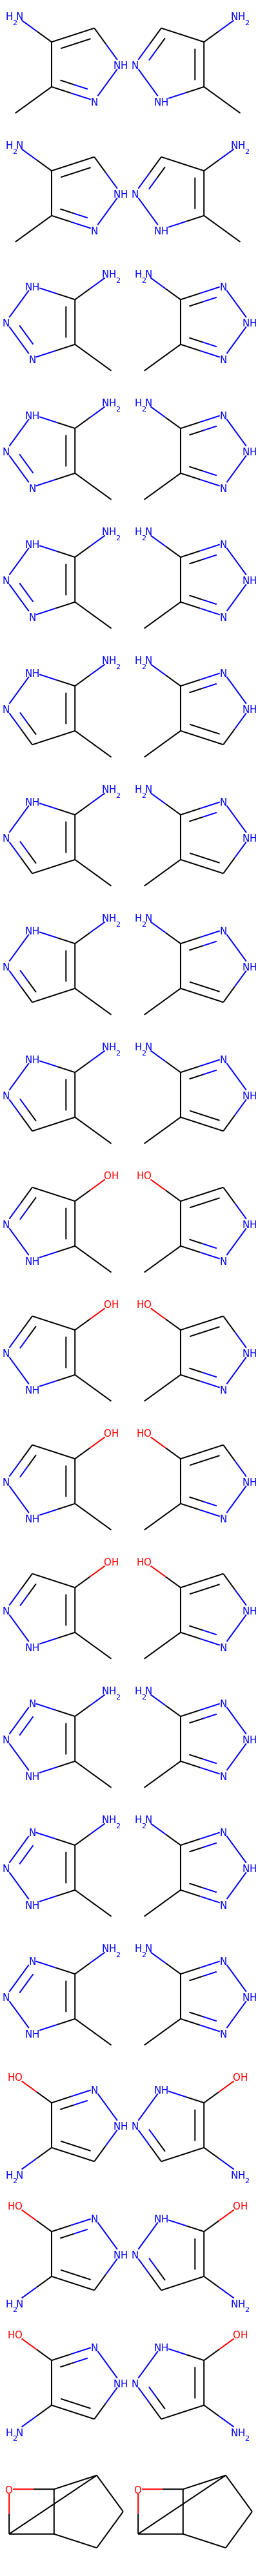

In [22]:
mols_row = atom_pairs[6.0][0]
mols_col = atom_pairs[6.0][1]

smiles = []
for molr, molc in zip(mols_row, mols_col):
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molr+'.xyz'))
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=2, subImgSize=(200, 200))

In [ ]:
atom_pairs[6.0][0][:5]

In [ ]:
distances[6.0]

### Nitrogen Atoms

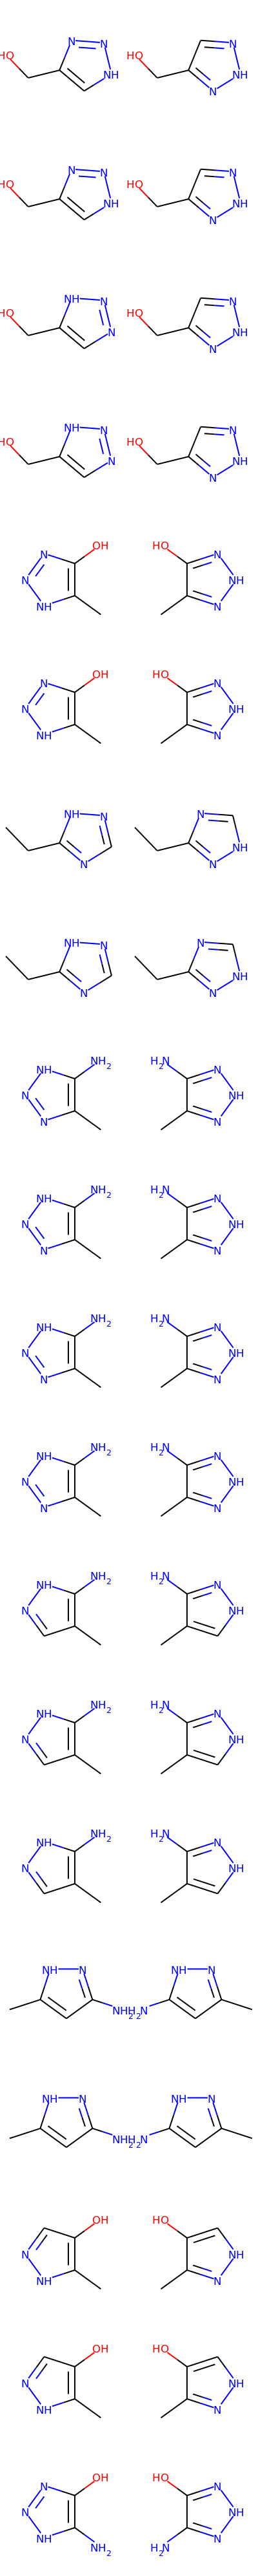

In [18]:
mols_row = atom_pairs[7.0][0]
mols_col = atom_pairs[7.0][1]

smiles = []
for molr, molc in zip(mols_row, mols_col):
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molr+'.xyz'))
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=2)

In [23]:
distances[7.0]

[3.1005684002652956,
 3.142737557164598,
 3.152505817938596,
 3.1626494523636066,
 3.162649452363607,
 3.1727701528290053,
 3.178816367132932,
 3.1826656672117983,
 3.1862706964961194,
 3.1877064494082137]

### Oxygen Atoms

In [152]:
mols_col

array(['dsgdb9nsd_003700', 'dsgdb9nsd_003858', 'dsgdb9nsd_003952',
       'dsgdb9nsd_001851'], dtype='<U16')

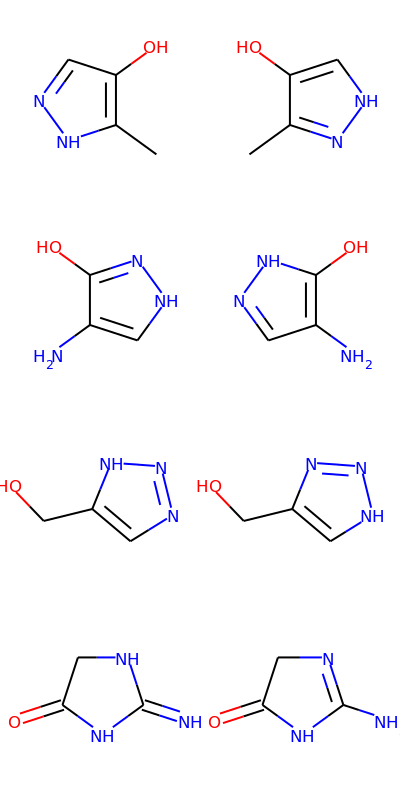

In [146]:
mols_row = atom_pairs[8.0][0][:4]
mols_col = atom_pairs[8.0][1][:4]

smiles = []
for molr, molc in zip(mols_row, mols_col):
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molr+'.xyz'))
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=2)

In [25]:
mols_row

array(['dsgdb9nsd_003699', 'dsgdb9nsd_003699', 'dsgdb9nsd_003661',
       'dsgdb9nsd_003661', 'dsgdb9nsd_003661', 'dsgdb9nsd_003660',
       'dsgdb9nsd_003660', 'dsgdb9nsd_003660', 'dsgdb9nsd_003660',
       'dsgdb9nsd_003664', 'dsgdb9nsd_003664', 'dsgdb9nsd_003664',
       'dsgdb9nsd_003664', 'dsgdb9nsd_003658', 'dsgdb9nsd_003658',
       'dsgdb9nsd_003658', 'dsgdb9nsd_003868', 'dsgdb9nsd_003868',
       'dsgdb9nsd_003868', 'dsgdb9nsd_003541'], dtype='<U16')

In [26]:
mols_col

array(['dsgdb9nsd_003656', 'dsgdb9nsd_003656', 'dsgdb9nsd_003702',
       'dsgdb9nsd_003702', 'dsgdb9nsd_003702', 'dsgdb9nsd_003678',
       'dsgdb9nsd_003678', 'dsgdb9nsd_003678', 'dsgdb9nsd_003678',
       'dsgdb9nsd_003700', 'dsgdb9nsd_003700', 'dsgdb9nsd_003700',
       'dsgdb9nsd_003700', 'dsgdb9nsd_003702', 'dsgdb9nsd_003702',
       'dsgdb9nsd_003702', 'dsgdb9nsd_003858', 'dsgdb9nsd_003858',
       'dsgdb9nsd_003858', 'dsgdb9nsd_003541'], dtype='<U16')

In [24]:
distances[8.0]

[3.186270696496119,
 3.2760836113744114,
 3.8065366892352066,
 3.8155651729645395,
 3.903777585727185,
 3.96133815901875,
 3.962210335038804,
 3.9850635769064695,
 4.029770511784403,
 4.057565018855323]

### Atom pairs for compounds where I already have dense grid

#### dsgdb9nsd_001212

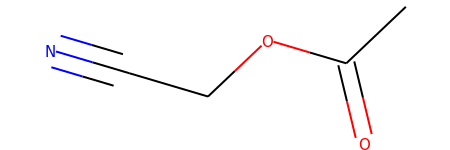

In [98]:
Chem.MolFromSmiles(get_smiles('/home/misa/datasets/qm9/'+'dsgdb9nsd_001212'+'.xyz'))

In [99]:
gi = np.where(mol_names == 'dsgdb9nsd_001212')[0]
qmi.get_local_idx(gi, molecule_size)

[1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261]

In [100]:
data[89][:,0]

array([6., 6., 8., 8., 6., 6., 7., 1., 1., 1., 1., 1.])

In [101]:
h = [1257, 1258, 1259, 1260, 1261]
c = [1250, 1251,1254, 1255]
n = [1256]
o = [1252, 1253]

li = {1.0:h, 6.0:c, 7.0:n, 8.0:o}

In [111]:
distances = dict()
atom_pairs = dict()
for  Z in [1.0, 6.0, 7.0, 8.0]:

    dmatrix = dmatrices[Z]
    min_dist_list = [0]
    ca = []
    ra = []

    for i in li[Z]:
        i2 = np.where(idc_by_charge[Z][0] == i)
        i2 = i2[0]
        ra.extend(i2)
        last_min = min_dist_list[-1]
        min_dist = np.amin(dmatrix[i2][np.where(dmatrix[i2] > last_min)])
        min_dist_list.append(min_dist)
        ca.extend(np.where(dmatrix[i2] == min_dist)[1])

        #atom_pairs_atoms[Z] = [ra, ca]
        #md.pop(0)
        distances[Z] = min_dist_list

        mols_Z_row = get_molecule_from_charge_partition(ra, Z, idc_by_charge, molecule_size, mol_names)
        mols_Z_cols = get_molecule_from_charge_partition(ca, Z, idc_by_charge, molecule_size, mol_names)

        atom_pairs[Z] = [mols_Z_row, mols_Z_cols]

In [116]:
distances

{1.0: [0,
  0.6499075845795049,
  4.536417050029364,
  4.537212346572872,
  4.669426180261141,
  4.670289491066134],
 6.0: [0,
  16.53042353809232,
  16.765832283181354,
  16.871072905165,
  17.075246414264228],
 7.0: [0, 16.53042353809232],
 8.0: [0, 11.804131074318578, 14.27551844139923]}

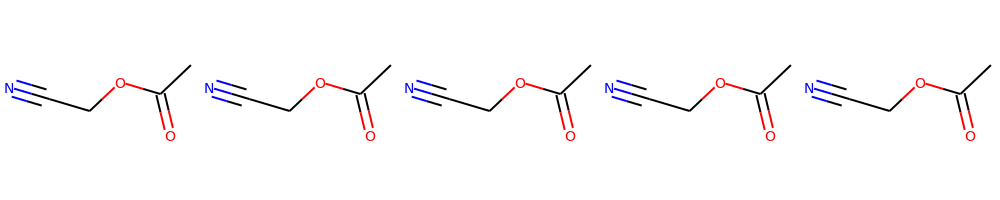

In [113]:
mols_col = atom_pairs[1.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=5)

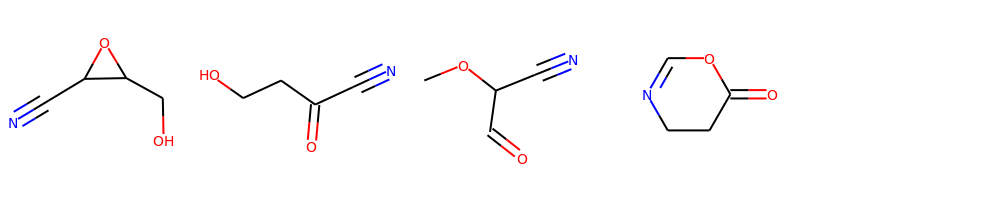

In [112]:
#mols_row = atom_pairs[6.0][0][:4]
mols_col = atom_pairs[6.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=5)

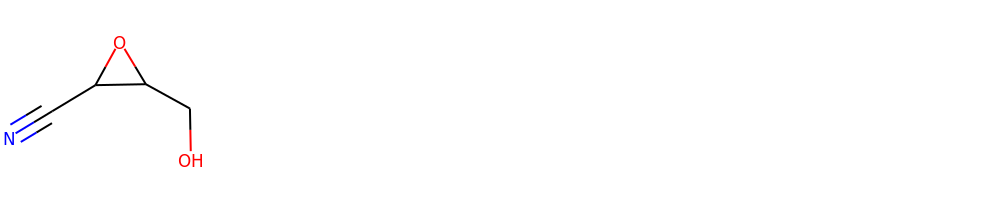

In [114]:
#mols_row = atom_pairs[6.0][0][:4]
mols_col = atom_pairs[7.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=5)

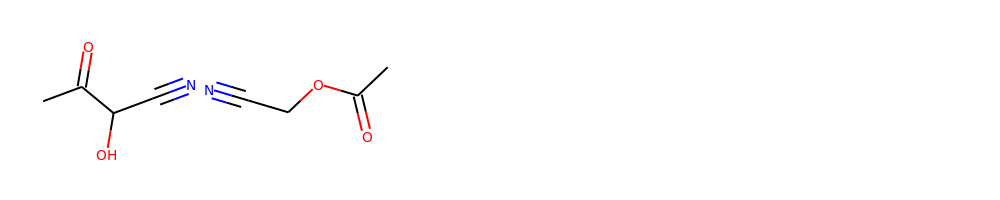

In [115]:
#mols_row = atom_pairs[6.0][0][:4]
mols_col = atom_pairs[8.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=5)

#### dsgdb9nsd_003712

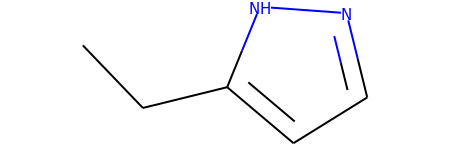

In [117]:
Chem.MolFromSmiles(get_smiles('/home/misa/datasets/qm9/'+'dsgdb9nsd_003712'+'.xyz'))

In [118]:
gi = np.where(mol_names == 'dsgdb9nsd_003712')[0]
qmi.get_local_idx(gi, molecule_size)

[6372,
 6373,
 6374,
 6375,
 6376,
 6377,
 6378,
 6379,
 6380,
 6381,
 6382,
 6383,
 6384,
 6385,
 6386]

In [120]:
data[gi[0]][:,0]

array([6., 6., 6., 6., 6., 7., 7., 1., 1., 1., 1., 1., 1., 1., 1.])

In [121]:
h = [6379,
 6380,
 6381,
 6382,
 6383,
 6384,
 6385,
 6386]
c = [6372,
 6373,
 6374,
 6375,
 6376]
n = [6377,
 6378]

li = {1.0:h, 6.0:c, 7.0:n}

In [124]:
distances = dict()
atom_pairs = dict()
for  Z in [1.0, 6.0, 7.0]:

    dmatrix = dmatrices[Z]
    min_dist_list = [0]
    ca = []
    ra = []

    for i in li[Z]:
        i2 = np.where(idc_by_charge[Z][0] == i)
        i2 = i2[0]
        ra.extend(i2)
        last_min = min_dist_list[-1]
        min_dist = np.amin(dmatrix[i2][np.where(dmatrix[i2] > last_min)])
        min_dist_list.append(min_dist)
        ca.extend(np.where(dmatrix[i2] == min_dist)[1])

        #atom_pairs_atoms[Z] = [ra, ca]
        #md.pop(0)
        distances[Z] = min_dist_list

        mols_Z_row = get_molecule_from_charge_partition(ra, Z, idc_by_charge, molecule_size, mol_names)
        mols_Z_cols = get_molecule_from_charge_partition(ca, Z, idc_by_charge, molecule_size, mol_names)

        atom_pairs[Z] = [mols_Z_row, mols_Z_cols]

In [129]:
distances

{1.0: [0,
  0.3429377657293764,
  0.5541625802447503,
  0.6550303116225564,
  4.112821304047392,
  4.848896358764414,
  5.088019679830913,
  5.1688813679257954,
  5.389880021684443],
 6.0: [0,
  7.068795023539302,
  7.068795023539303,
  10.972723742290142,
  11.619754643113271,
  11.77723288869107],
 7.0: [0, 7.068795023539302, 10.972723742290142]}

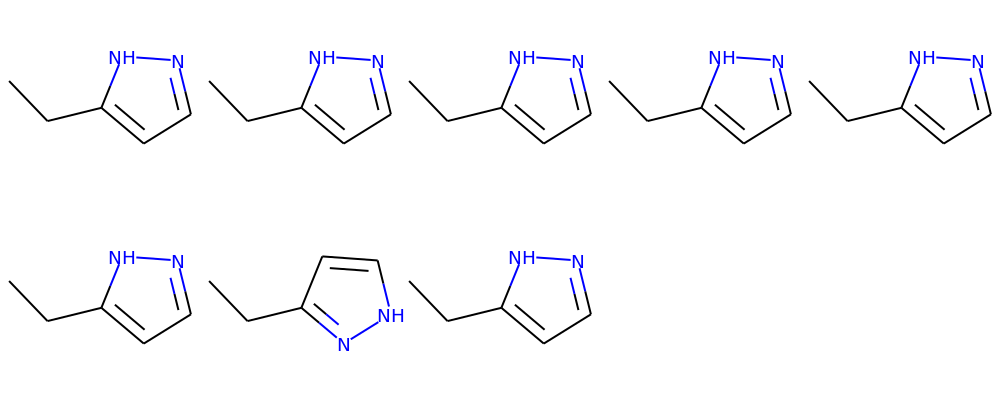

In [125]:
mols_col = atom_pairs[1.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=5)

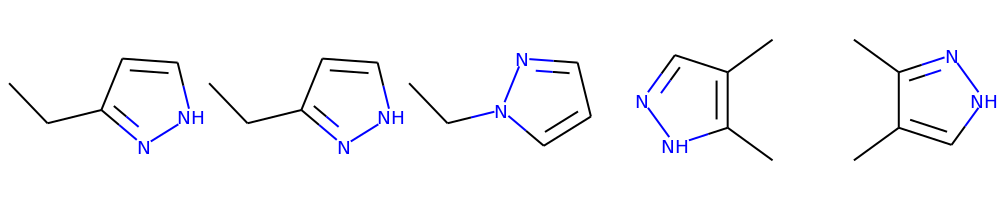

In [126]:
mols_col = atom_pairs[6.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=5)

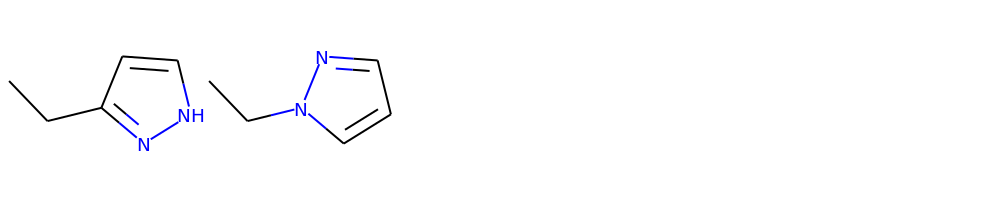

In [127]:
mols_col = atom_pairs[7.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=5)

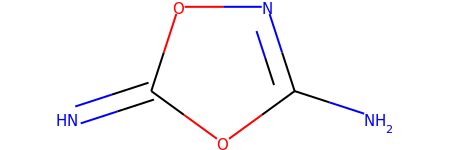

In [130]:
Chem.MolFromSmiles(get_smiles('/home/misa/datasets/qm9/'+'dsgdb9nsd_003886'+'.xyz'))

In [131]:
gi = np.where(mol_names == 'dsgdb9nsd_003886')[0]
qmi.get_local_idx(gi, molecule_size)

[7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118]

In [132]:
data[gi[0]][:,0]

array([7., 6., 7., 8., 6., 7., 8., 1., 1., 1.])

In [134]:
h = [7116, 7117, 7118]
c = [7110, 7113]
n = [7109, 7111, 7114]
o = [7112,7115]

li = {1.0:h, 6.0:c, 7.0:n, 8.0:o}

In [135]:
distances = dict()
atom_pairs = dict()
for  Z in [1.0, 6.0, 7.0, 8.0]:

    dmatrix = dmatrices[Z]
    min_dist_list = [0]
    ca = []
    ra = []

    for i in li[Z]:
        i2 = np.where(idc_by_charge[Z][0] == i)
        i2 = i2[0]
        ra.extend(i2)
        last_min = min_dist_list[-1]
        min_dist = np.amin(dmatrix[i2][np.where(dmatrix[i2] > last_min)])
        min_dist_list.append(min_dist)
        ca.extend(np.where(dmatrix[i2] == min_dist)[1])

        #atom_pairs_atoms[Z] = [ra, ca]
        #md.pop(0)
        distances[Z] = min_dist_list

        mols_Z_row = get_molecule_from_charge_partition(ra, Z, idc_by_charge, molecule_size, mol_names)
        mols_Z_cols = get_molecule_from_charge_partition(ca, Z, idc_by_charge, molecule_size, mol_names)

        atom_pairs[Z] = [mols_Z_row, mols_Z_cols]

In [136]:
distances

{1.0: [0, 0.6832196598261367, 6.249166326698068, 23.48493281729813],
 6.0: [0, 23.48493281729813, 24.04073658875479],
 7.0: [0, 23.48493281729813, 23.601691260115704, 24.052150593971664],
 8.0: [0, 15.534793457597686, 23.48493281729813]}

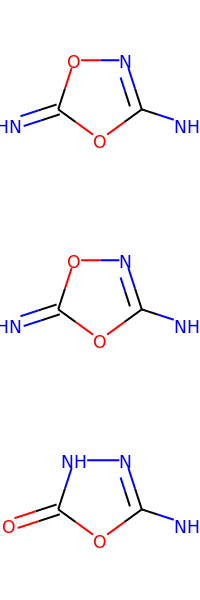

In [138]:
mols_col = atom_pairs[1.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=1)

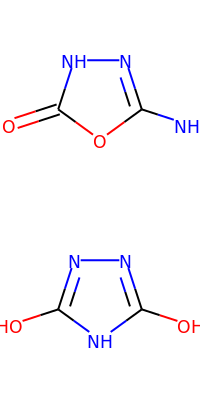

In [139]:
mols_col = atom_pairs[6.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=1)

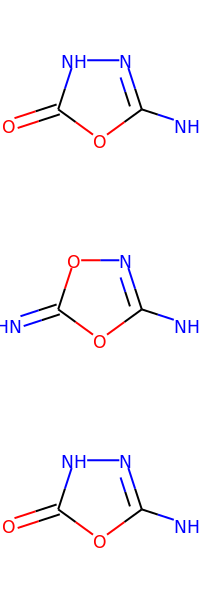

In [140]:
mols_col = atom_pairs[7.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=1)

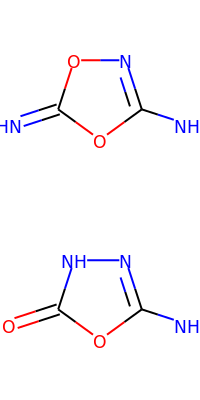

In [141]:
mols_col = atom_pairs[8.0][1]

smiles = []
for molc in mols_col:
    smiles.append(get_smiles('/home/misa/datasets/qm9/'+molc+'.xyz'))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms, molsPerRow=1)